# SARSA

## Summary

- Custom Grid Environment (refer to grid_environment folder for more information)
- Class for Q Learning algorithm
- Q Learning implementation on custom grid environment
- Analysis of Q Learning implementation

In [1]:
# Imports

import cv2
import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

### RL Grid Environment

In [2]:
# Grid Environment Class

class GridEnvironment(gym.Env):    
    def __init__(self, environment_type):
        self.environment_type = environment_type
        self.environment_width = 6
        self.environment_height = 6
        
        self.observation_space = gym.spaces.Discrete(self.environment_width * self.environment_height)
        self.action_space = gym.spaces.Discrete(4)
        
        self.max_timesteps = 20
        self.timestep = 0          
        self.agent_pos = np.asarray([0, 0])
        self.current_state = np.asarray([0, 0])
        self.next_state = np.asarray([0, 0])
        self.gold_pos = np.asarray([4, 5])
        self.gold_quantity = 1
        self.coin_pos = np.asarray([[0,2], [0,4], [1,5], [2,0], [2,2], [2,5], [3,3], [4,0], [4,4], [5,5]])
        self.stack_pos = np.asarray([[1,3], [4,1]]) 
        self.pit_pos = np.asarray([[0,3], [1,1], [2,4], [3,0], [4,2], [5,0], [5,3]])
        
    def reset(self, **kwargs):
        self.timestep = 0          
        self.agent_pos = np.asarray([0, 0])
        self.agent_pos = np.asarray([0, 0])
        self.current_state = np.asarray([0, 0])
        self.gold_pos = np.asarray([4, 5])
        self.gold_quantity = 1
        self.coin_pos = np.asarray([[0,2], [0,4], [1,5], [2,0], [2,2], [2,5], [3,3], [4,0], [4,4], [5,5]])
        self.stack_pos = np.asarray([[1,3], [4,1]]) 
        self.pit_pos = np.asarray([[0,3], [1,1], [2,4], [3,0], [4,2], [5,0], [5,3]])
            
        return self.current_state
        
    def step(self, action):
       
        # Stochastic Environment
        random_number = np.random.uniform(0, 1)
        if self.environment_type == 'stochastic' and random_number >= 0.9:
            action = np.random.choice(self.action_space.n)
            
        if action == 0:
            self.agent_pos[0] += 1  # This action causes the agent to go right.
        if action == 1:
            self.agent_pos[0] -= 1  # This action causes the agent to go left.
        if action == 2:
            self.agent_pos[1] += 1  # This action causes the agent to go up.
        if action == 3:
            self.agent_pos[1] -= 1  # This action causes the agent to go down.

        self.agent_pos = np.clip(self.agent_pos, 0, 5) 
        
        self.next_state = self.agent_pos
        
        terminated = True if self.timestep >= self.max_timesteps else False
        truncated = True if np.all((self.agent_pos >= 0 ) & (self.agent_pos <= 2)) else False
        
        reward = 0
        agent_list = self.agent_pos.tolist()
        gold_list = self.gold_pos.tolist()
        coin_list = self.coin_pos.tolist()
        stack_list = self.stack_pos.tolist()
        pit_list = self.pit_pos.tolist()         
        
        if agent_list == gold_list:
            reward = 100
            self.gold_pos = np.asarray([])
            terminated = True
        if agent_list in coin_list:
            reward = 1
            coin_list.remove(agent_list)
            self.coin_pos = np.asarray(coin_list)
        if agent_list in stack_list:
            reward = 10
            stack_list.remove(agent_list)
            self.stack_pos = np.asarray(stack_list)
        if agent_list in pit_list:
            reward = -2
            pit_list.remove(agent_list)
            self.pit_pos = np.asarray(pit_list)
        
        self.timestep += 1
        
        return self.next_state, reward, terminated

### SARSA Algorithm

In [3]:
# SARSA Algorithm class

class SARSA():
    def __init__(self, environment):
        self.environment = environment
        self.observation_space = environment.observation_space.n
        self.action_space = environment.action_space.n
        
        self.q_table = np.zeros((self.observation_space, self.action_space))        
        
        self.num_episodes = 10000
        self.iter_episodes = 100

        self.gamma = 0.99
        self.alpha = 0.1

        self.epsilon = 1
        self.decay_factor = 0.001
        self.min_epsilon = 0.01

        self.rewards_per_episode = []
        self.iterations_per_episode = []
        self.iterations = []
        for e in range(self.num_episodes):
            self.iterations.append(e)
        self.epsilon_values = []
        
    def map_state(self):
        state_map = [0] * self.observation_space
        iter_val = int(np.sqrt(self.observation_space))
        s = 0
        for i in range(iter_val):
            for j in range(iter_val):
                state_map[s] = [i, j]
                s += 1
        return state_map
    
    def choose_action(self, index):
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            action = np.argmax(self.q_table[index,:])
        return action
            
    def update(self):
        state_map = self.map_state()
        for e in range(self.num_episodes):
            current_state = self.environment.reset()
            action1 = self.choose_action(current_state)
            terminated, truncated = False, False

            total_reward = 0

            for i in range(self.iter_episodes):
                next_state, reward, terminated = self.environment.step(action1)

                current_state = np.clip(current_state, 0, 5)
                next_state = np.clip(next_state, 0, 5)

                current_index = state_map.index(current_state.tolist())
                next_index = state_map.index(next_state.tolist())
                action2 = self.choose_action(next_index)                
                
                # SARSA update function
                self.q_table[current_index, action1] = self.q_table[current_index, action1] + \
                    self.alpha*(reward + self.gamma*self.q_table[next_index, action2] - self.q_table[current_index, action1])

                current_state = next_state
                action1 = action2
        
                total_reward += reward

                if terminated:
                    break

            self.iterations_per_episode.append(i)
            self.rewards_per_episode.append(total_reward)
            self.epsilon_values.append(self.epsilon)

            self.epsilon = max(self.min_epsilon, np.exp(-self.decay_factor*e))        

In [4]:
grid_world = GridEnvironment('deterministic')
sarsa = SARSA(grid_world)

sarsa.update()

In [5]:
sarsa.q_table

array([[ 9.66842755e+01,  9.69783348e+01,  9.86739072e+01,
         9.63452617e+01],
       [ 9.65871766e+01,  9.69537627e+01,  1.00434672e+02,
         9.75738572e+01],
       [ 1.02405237e+02,  9.78283745e+01,  9.66350747e+01,
         9.87500937e+01],
       [ 9.93302360e+01,  6.51493899e+01,  3.89484729e+01,
         6.73540223e+01],
       [ 2.18810315e+01,  1.21091921e+01,  1.49630833e+00,
         6.83311881e+01],
       [ 1.11831670e+01,  1.30140862e+00,  1.18194590e+00,
         3.74685581e+00],
       [ 1.06562243e+01,  9.97861936e+01,  3.66703825e+01,
         2.74154271e+01],
       [ 3.60756654e+01,  6.59559142e+01,  1.00305973e+02,
         4.54528664e+01],
       [ 9.75246890e+01,  9.78072483e+01,  1.05672286e+02,
         9.70533574e+01],
       [ 9.78684894e+01,  9.65151653e+01,  9.61453830e+01,
         9.77756380e+01],
       [ 6.52393648e+01,  2.72597963e+01,  2.05648088e+01,
         9.70847345e+01],
       [ 5.56071058e+00,  1.54107056e+00,  5.32139179e+00,
      

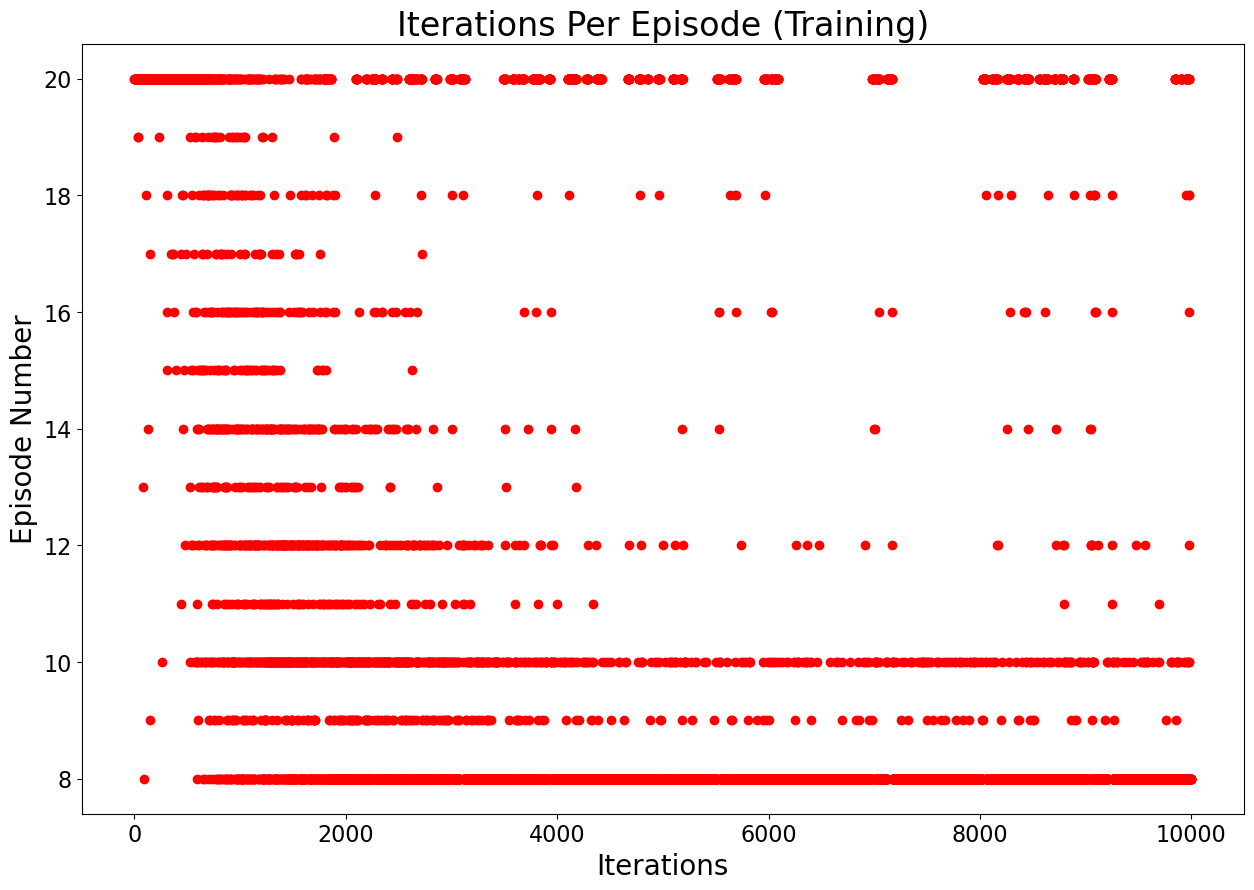

In [6]:
# Number of iterations per epsisode

plt.figure(figsize=(15, 10))
plt.plot(sarsa.iterations, sarsa.iterations_per_episode, 'ro')
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('Episode Number', fontsize=20)
plt.title('Iterations Per Episode (Training)', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

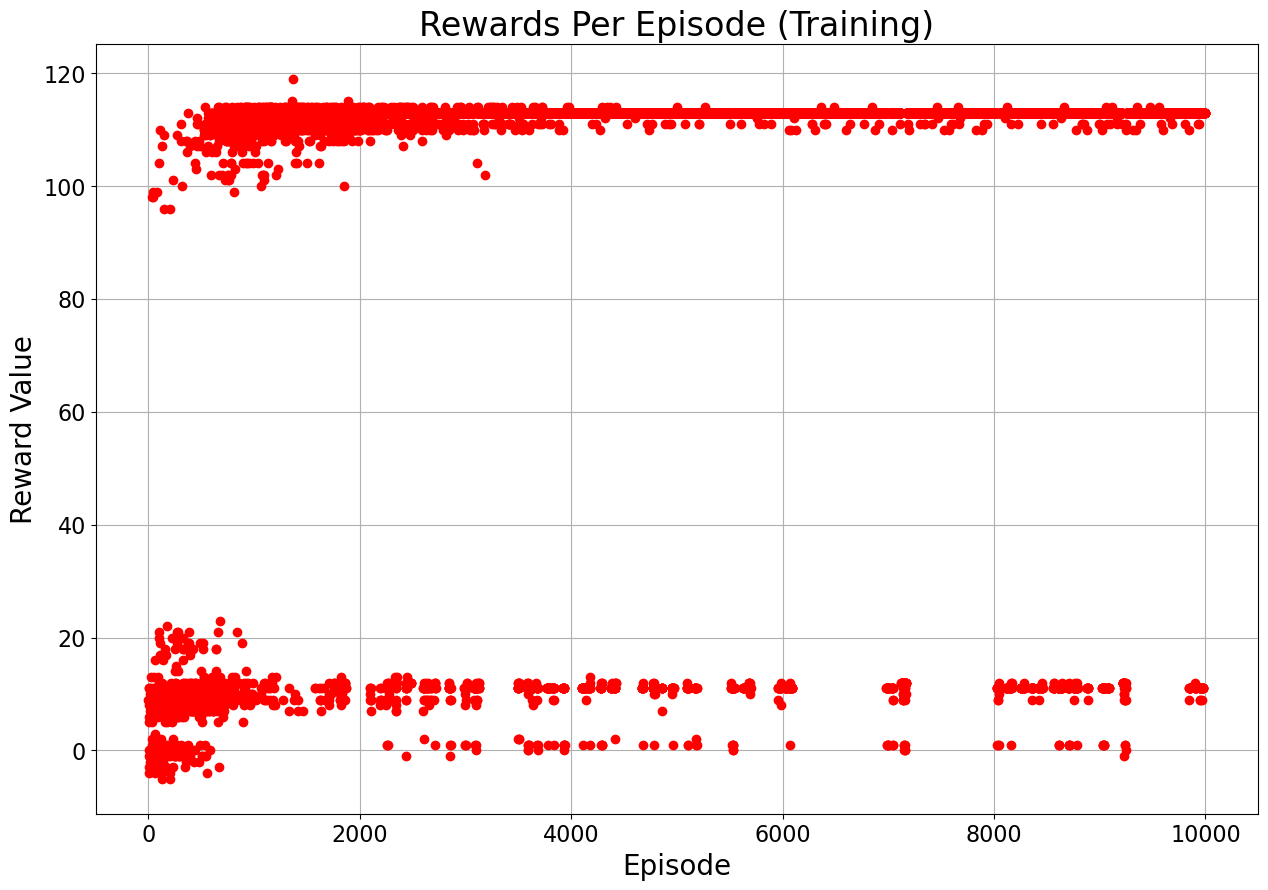

In [7]:
# Reward value per episode

plt.figure(figsize=(15, 10))
plt.plot(sarsa.rewards_per_episode, 'ro')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward Value', fontsize=20)
plt.title('Rewards Per Episode (Training)', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.show()

In [8]:
# Mean reward per thousand episode

mean_reward = []
iteration_thousand = []
print("Mean reward per thousand episodes")
for i in range(10):
    mean_reward.append(np.mean(sarsa.rewards_per_episode[1000*i:1000*(i+1)]))
    iteration_thousand.append((i+1)*1000)
    print(((i+1)*1000), ': mean reward :', mean_reward[i])

Mean reward per thousand episodes
1000 : mean reward : 43.897
2000 : mean reward : 104.232
3000 : mean reward : 98.634
4000 : mean reward : 97.56
5000 : mean reward : 99.525
6000 : mean reward : 101.654
7000 : mean reward : 108.033
8000 : mean reward : 106.135
9000 : mean reward : 94.088
10000 : mean reward : 102.349


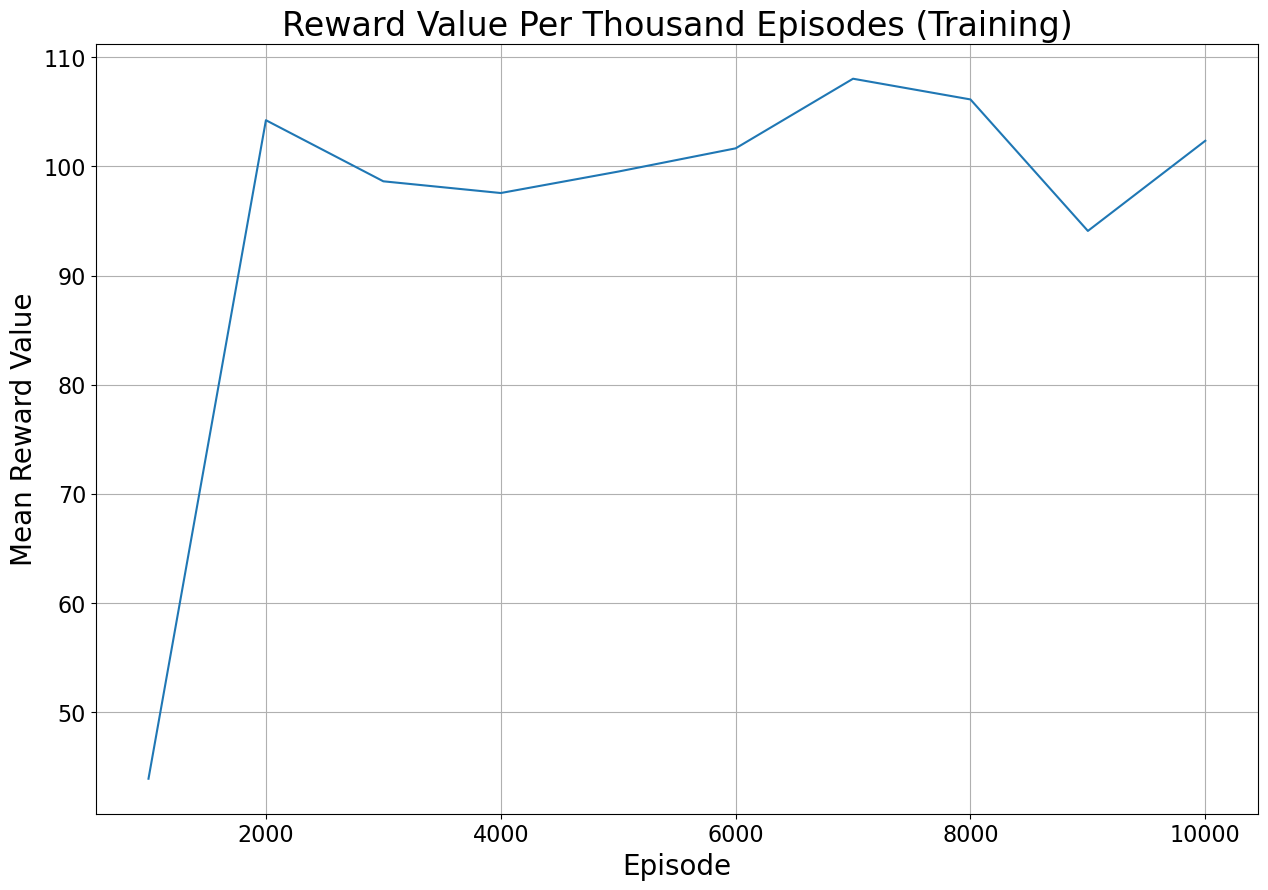

In [9]:
plt.figure(figsize=(15, 10))
plt.plot(iteration_thousand, mean_reward)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Mean Reward Value', fontsize=20)
plt.title('Reward Value Per Thousand Episodes (Training)', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.show()

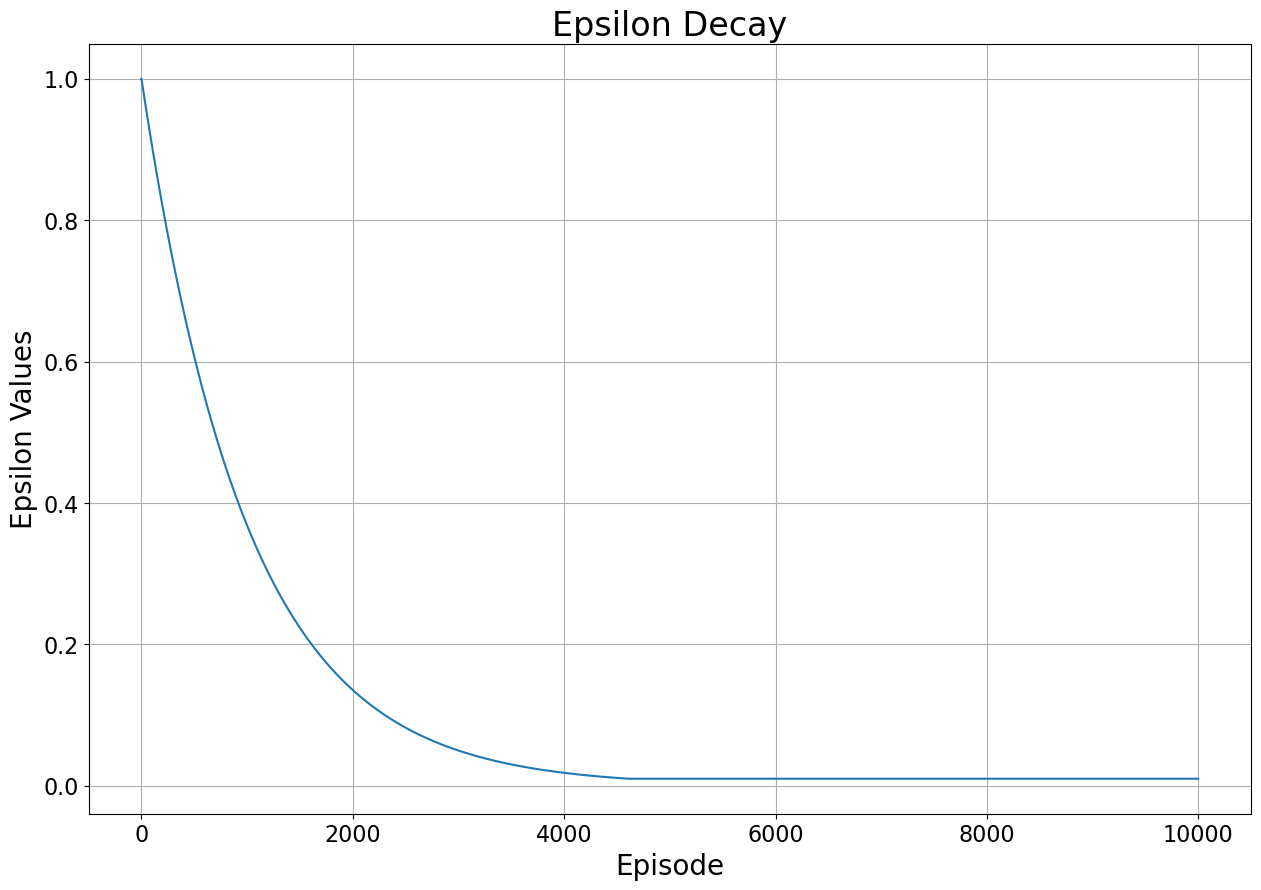

In [10]:
# Epsilon decay

plt.figure(figsize=(15, 10))
plt.plot(sarsa.epsilon_values)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Epsilon Values', fontsize=20)
plt.title('Epsilon Decay', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.show()